In [3]:
import numpy as np
import json
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import time
import os
import copy
import random
from collections import Counter

batch_size  = 64
random_seed = 9688
random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
# Beer Class
class_names = {
    '0': "asahi",      
    '1': "kronenbourg1664blanc",  
    '2': "carlsberg",
    '3': "cassfresh",
    '4': "casslight",
    '5': "filitebarley",
    '6': "filitefresh",
    '7': "guinnessdraught",
    '8': "heineken",
    '9': "hoegaarden",
    '10': "hophouse13",
    '11': "kloud",
    '12': "kozeldark",
    '13': "pilsnerurquell",
    '14': "fitz",
    '15': "sapporo",
    '16': "stellaartois",
    '17': "terra",
    '18': "tiger",
    '19': "tsingtao",
    '20': "gompyo",
    '21': "malpyo",
    '22': "grimbergenblanche",
    '23': "macarthur",
    '24': "budweiser",
    '25': "becks",
    '26': "bluemoons",
    '27': "sunhanipa",
    '28': "jejuwitale",
    '29': "jejupellongale",
    '30': "kronenbourg1664lager",
    '31': "klouddraft",
    '32': "filgoodseven",
    '33': "filgoodoriginal",
    '34': "hiteextracold",
    '35': "heungcheongmangcheong",
    '36': "somersby",
    '37': "desperadosoriginal",
    '38': "paulanerweissbier",
    '39': "guinnessoriginal",
    '40': "filiteweizen",
    '41': "heinekendark",
    '42': "leffebrune",
    '43': "peroni",
    '44': "gooseisland312",
    '45': "tigerradlergrapefruit",
    '46': "gwanghwamun",
    '47': "seongsanilchulbong"
}

n_classes = len(class_names)

In [5]:
## Split path to train/valid/test
import splitfolders
import shutil
from glob import glob

old_path = 'can_data'
new_path = 'can_data_split'

# 경로 지우기 전 항상 확인
if False:
    shutil.rmtree(new_path)

if not os.path.isdir(new_path):
    splitfolders.ratio(old_path, output=new_path, seed=random_seed, ratio=(.8, .15, .05), group_prefix=None) # default values
    # splitfolders.fixed("input_folder", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values
    
    print('Path Splitted')

In [6]:
# Transform Settings
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=(-30, 30)),
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomChoice([
                                    transforms.RandomHorizontalFlip(p=0.1),
                                    transforms.RandomVerticalFlip(p=0.1)
                                ]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet standards
    ]),
    
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Datasets from folders
train_dir = f'{new_path}/train'
valid_dir = f'{new_path}/val'
test_dir = f'{new_path}/test'

data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}
print(f"data : {len(data['train'])} / {len(data['valid'])} / {len(data['test'])}")

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=10),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, num_workers=10),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, num_workers=10)
}
print(f"batch_size : {batch_size}, iter : {len(dataloaders['train'])} / {len(dataloaders['valid'])} / {len(dataloaders['test'])}")

data : 9070 / 1681 / 610
batch_size : 64, iter : 142 / 27 / 10


In [ ]:
# Check data
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [8]:
# Train method

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
            
        epoch_end = time.time() - epoch_start
        print('Epoch elapsed time : {:.0f}m {:.0f}s'.format(epoch_end // 60, epoch_end % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'Resnet50_48class_1206.pt')
    print('model saved')
    
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
# model.load_state_dict(torch.load('pretrained/Resnet18_48class.pt'))

# fix option
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.72 Acc: 81.2
valid Loss: 0.83 Acc: 79.7
==> best model saved - 0 / 79.7
Epoch elapsed time : 3m 37s
Epoch 1/99
----------
train Loss: 0.26 Acc: 93.0
valid Loss: 0.49 Acc: 88.9
==> best model saved - 1 / 88.9
Epoch elapsed time : 3m 37s
Epoch 2/99
----------
train Loss: 0.20 Acc: 94.6
valid Loss: 0.35 Acc: 90.5
==> best model saved - 2 / 90.5
Epoch elapsed time : 3m 36s
Epoch 3/99
----------
train Loss: 0.15 Acc: 95.7
valid Loss: 0.19 Acc: 95.2
==> best model saved - 3 / 95.2
Epoch elapsed time : 3m 35s
Epoch 4/99
----------
train Loss: 0.12 Acc: 96.7
valid Loss: 0.14 Acc: 96.4
==> best model saved - 4 / 96.4
Epoch elapsed time : 3m 35s
Epoch 5/99
----------
train Loss: 0.14 Acc: 96.0
valid Loss: 0.16 Acc: 96.5
==> best model saved - 5 / 96.5
Epoch elapsed time : 3m 36s
Epoch 6/99
----------
train Loss: 0.11 Acc: 96.8
valid Loss: 0.10 Acc: 97.1
==> best model saved - 6 / 97.1
Epoch elapsed time : 3m 37s
Epoch 7/99
----------
train Loss: 0.04 Acc: 98.9

train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.6
Epoch elapsed time : 3m 47s
Epoch 75/99
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 43s
Epoch 76/99
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 42s
Epoch 77/99
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.02 Acc: 99.6
Epoch elapsed time : 3m 42s
Epoch 78/99
----------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.02 Acc: 99.6
Epoch elapsed time : 3m 42s
Epoch 79/99
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 43s
Epoch 80/99
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 43s
Epoch 81/99
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 44s
Epoch 82/99
----------
train Loss: 0.01 Acc: 99.8
valid Loss: 0.02 Acc: 99.5
Epoch elapsed time : 3m 43s
Epoch 83/99
----------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.02 Acc: 99.6
E

best model : 57 - 100 / 0.0


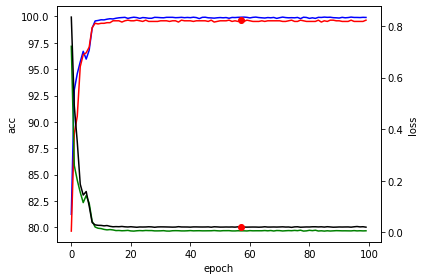

In [13]:
## Result
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

# model = rexnetv1.ReXNetV1(width_mult=1.0, classes=len(class_names)).cuda()
model.load_state_dict(torch.load('Resnet50_48class_1206.pt'))
model = model.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def test_and_visualize_model(model, phase = 'test', num_images=5):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            
            print(len(inputs))
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(0, len(inputs)):
                ax = plt.subplot(4, 4, 1)
                ax.axis('off')
                
                test_correct = class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())]
                
                if not test_correct:
                    ax.set_title('%s : %s -> %s'%(str(test_correct),
                        class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                    imshow(inputs.cpu().data[j])
#             if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
## TEST!
test_and_visualize_model(model, phase = 'test', num_images=64)

In [ ]:
# Transform Settings

A

image_transforms = {
    # Train uses data augmentation
    'train':
    A.Compose([
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
        A.OneOf([
            A.Flip(),
            A.RandomRotate90(),
            A.Rotate
        ], p=0.3),
        A.OneOf([
            A.MotionBlur(p=1),
            A.OpticalDistortion(p=1),
            A.GaussNoise(p=1),
            A.Cutout(num_holes=30)
        ], p=0.3),
        
        A.RandomBrightness()
        
        A.pytorch.ToTensor(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # Imagenet standards
    ]),
    
    # Validation does not use augmentation
    'valid':
    A.Compose([
        A.Resize((224, 224)),
        A.ToTensor(),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

        # Test does not use augmentation
    'test':
    A.Compose([
        A.Resize((224, 224)),
        A.ToTensor(),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])


def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

        
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)